In [104]:
import os
import numpy as np 
import pandas as pd 
from datetime import datetime
import time
import random
from tqdm.auto import tqdm


#Torch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SequentialSampler, RandomSampler
import torchvision.transforms as T

#sklearn
from sklearn.model_selection import StratifiedKFold
from skimage import io

################# DETR FUCNTIONS FOR LOSS######################## 
import sys
sys.path.append('./detr_custom/')

from models.matcher import HungarianMatcher
from models.detr import SetCriterion
#################################################################

import matplotlib.pyplot as plt

#Glob
from glob import glob

from typing import Iterable
import albumentations as A
from albumentations.pytorch import ToTensorV2
from PIL import Image
from generators import BlenderStandardDataset, TorchStandardDataset

In [59]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    
def pytorch_init_janus_gpu():
    device_id = 1
    torch.cuda.set_device(device_id)
    
    # Sanity checks
    assert torch.cuda.current_device() == 1, 'Using wrong GPU'
    assert torch.cuda.device_count() == 2, 'Cannot find both GPUs'
    assert torch.cuda.get_device_name(0) == 'GeForce RTX 2080 Ti', 'Wrong GPU name'
    assert torch.cuda.is_available() == True, 'GPU not available'
    return torch.device('cuda', device_id)

In [60]:
seed = 42069
seed_everything(seed)

try:
    device = pytorch_init_janus_gpu()
    print(f'Using device: {device} ({torch.cuda.get_device_name()})')
except AssertionError as e:
    print('GPU could not initialize, got error:', e)
    device = torch.device('cpu')
    print('Device is set to CPU')

Using device: cuda:1 (GeForce RTX 2080 Ti)


In [61]:
TORCH_CACHE_DIR = 'torch_cache'
torch.hub.set_dir(TORCH_CACHE_DIR)
model = torch.hub.load(os.path.join(TORCH_CACHE_DIR, 'facebookresearch_detr_master'), model='detr_resnet50', pretrained=True, source='local').to(device)

In [62]:
#.rotate creates black bars
img = Image.open('test_image2.png')
w, h = img.size

In [63]:
transform = T.Compose([
    T.Resize(800),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

In [64]:
input_img = transform(img)

In [65]:
with torch.no_grad():
    output = model(input_img.unsqueeze(0).to(device))

In [66]:
boxes = output['pred_boxes'][0]
logits = output['pred_logits'][0]

In [114]:
TORCH_CACHE_DIR = 'torch_cache'
DATASET_DIR = '/mnt/blendervol/objdet_std_data'
SQL_TABLE = 'bboxes_std'
WEIGHTS_DIR = 'fish_statedicts'
torchdataset = TorchStandardDataset(DATASET_DIR, SQL_TABLE, 1, shuffle=False, imgnrs=range(0,32))

In [123]:
def box_xywh_to_cxcywh(bboxes: torch.Tensor):
    '''
    top left point with width height to box center and width and height
    '''
    newtensor = bboxes.detach().clone()
    # (cx, cy, w, h)
    newtensor[:,0] = newtensor[:,0] - newtensor[:,2] * 0.5
    newtensor[:,1] = newtensor[:,1] - newtensor[:,3] * 0.5
    print(bboxes)
    print(newtensor)
    
__, y__ = torchdataset[0]
box_xywh_to_cxcywh(boxes)

tensor([[0.1652, 0.7499, 0.0308, 0.1025],
        [0.4133, 0.5970, 0.0405, 0.1137],
        [0.2089, 0.8039, 0.0337, 0.2156],
        [0.5545, 0.2838, 0.0461, 0.2104],
        [0.4086, 0.5820, 0.0489, 0.1197],
        [0.4081, 0.5864, 0.0517, 0.1131],
        [0.4217, 0.6684, 0.0194, 0.0468],
        [0.2666, 0.7582, 0.0506, 0.0963],
        [0.2347, 0.6733, 0.0336, 0.0843],
        [0.0249, 0.0133, 0.0358, 0.0268],
        [0.6187, 0.6558, 0.0549, 0.0261],
        [0.1653, 0.7951, 0.0333, 0.2201],
        [0.8738, 0.3281, 0.1342, 0.5963],
        [0.6446, 0.6543, 0.0427, 0.0170],
        [0.3680, 0.8816, 0.0431, 0.0262],
        [0.2194, 0.6880, 0.0236, 0.0901],
        [0.0279, 0.0146, 0.0248, 0.0288],
        [0.8407, 0.2167, 0.0672, 0.3503],
        [0.6460, 0.6551, 0.0434, 0.0174],
        [0.5087, 0.6262, 0.2262, 0.1823],
        [0.7781, 0.5672, 0.2137, 0.1215],
        [0.7725, 0.5642, 0.2238, 0.1057],
        [0.5498, 0.3190, 0.7597, 0.6360],
        [0.8821, 0.5115, 0.0486, 0

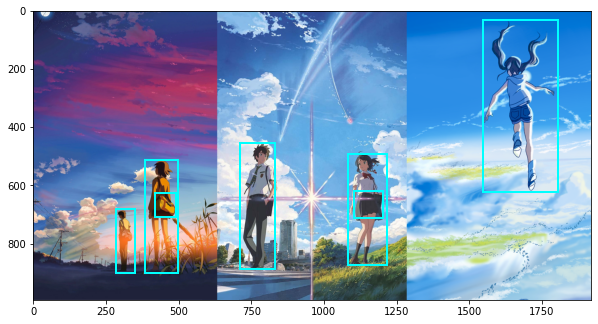

In [102]:
def postprocess2(logits: torch.Tensor, boxes: torch.Tensor):
    keepmask = logits.softmax(-1)[:,:-1].max(-1)[0] > 0.5
    if not any(keepmask):
        return torch.Tensor(), torch.Tensor()
    return logits[keepmask].argmax(-1), boxes[keepmask]

logits_, boxes_ = postprocess2(logits, boxes)

def plot_results2(img: Image.Image, classes: Iterable, boxes: Iterable):
    npimg = np.array(img)
    h, w = np.array(img).shape[:2]
    
    fig, ax = plt.subplots(1,1,figsize=(10,7))
    
    ax.imshow(npimg)

    for class_, bbox in zip(classes, boxes):
        bx, by, bw, bh = bbox
        ax.add_patch(plt.Rectangle((w*bx-bw*w/2,h*by-bh*h/2), bw*w, bh*h, fill=False, color='cyan', linewidth=2))
    
plot_results2(img, logits_, boxes_)

In [67]:
def postprocess(logits: torch.Tensor, boxes: torch.Tensor):
    keepmask = logits.softmax(-1)[:,:-1].max(-1)[0] > 0.7
    return logits[keepmask].argmax(-1), boxes[keepmask]

logits_, boxes_ = postprocess(logits, boxes)

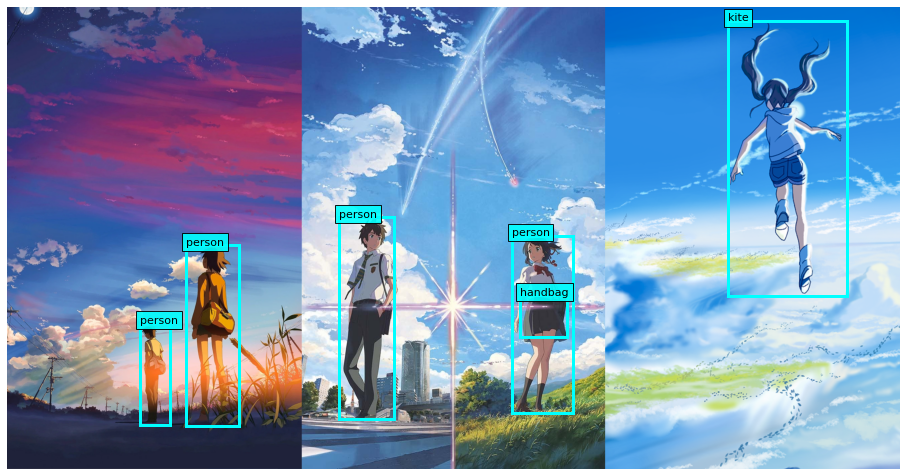

In [68]:
# COCO classes
CLASSES = [
    'N/A', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A',
    'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse',
    'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack',
    'umbrella', 'N/A', 'N/A', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis',
    'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove',
    'skateboard', 'surfboard', 'tennis racket', 'bottle', 'N/A', 'wine glass',
    'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich',
    'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake',
    'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table', 'N/A',
    'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard',
    'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A',
    'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier',
    'toothbrush'
]

def box_cxcywh_to_xyxy(x: torch.Tensor):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)

def plot_results(img: Image.Image, classes: Iterable, boxes: Iterable):
    boxes = box_cxcywh_to_xyxy(boxes)
    fig, ax = plt.subplots(figsize=(16,10))
    plt.imshow(img)
    
    w, h = img.size

    boxes[:,[0,2]] *= w
    boxes[:,[1,3]] *= h

    for cls, (xmin, ymin, xmax, ymax) in zip(classes, boxes):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color='cyan', linewidth=3))
        try:
            ax.text(xmin, ymin, CLASSES[cls], fontsize=11, bbox=dict(facecolor='cyan', alpha=0.9))
        except:
            pass
            
    plt.axis('off')
    plt.show()
    
plot_results(img, logits_, boxes_)